In [1]:
import os

import torch
from torch.autograd import Variable


import numpy as np
from time import time
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.interpolate import griddata

os.chdir("..")

from Galab import llaplace
from NN import DNN_Ensemble,DNN,Dropout_DNN

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Heat Equation

$$\frac{\partial u}{\partial t} = k \frac{\partial^{2} u}{\partial x^{2}} + sin(5 \pi x)$$
$$u(x,0) = 4sin(3 \pi x)+ 9sin(7 \pi x),  u(0,t)=u(1,t)=0$$

In [2]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u    

In [3]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u[:,0], data_domain, 
        grad_outputs=torch.ones_like(u[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)- torch.sin(5*torch.pi*data_domain[:,0].reshape(-1,1))

    return torch.cat([f,u[:,1].reshape(-1,1)], axis = 1)

def ini_c(self,data_inic):
    u = self(data_inic)
    inic = u[:,0].reshape(-1,1) - 4*torch.sin(3*torch.pi*data_inic[:,0].reshape(-1,1)) - 9*torch.sin(7*torch.pi*data_inic[:,0].reshape(-1,1))
    return torch.cat([inic,u[:,1].reshape(-1,1)], axis = 1)

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [4]:
DNN_Ensemble.de = de
DNN_Ensemble.ini_c = ini_c
DNN_Ensemble.left_bc = left_bc
DNN_Ensemble.right_bc = right_bc

In [5]:
def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [6]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(x).float(),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [7]:
def train_adam(pinn,optimizer,epochs, sample_size = 100, minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True).to(device),Variable(ini_c,requires_grad=True).to(device)
        left_bc,right_bc = Variable(left_bc,requires_grad=True).to(device),Variable(right_bc,requires_grad=True).to(device)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
                loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
                loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
                loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc + 10
                train_loss.append(Loss.item())
                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
      return train_loss

In [8]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True).to(device),Variable(ini_c,requires_grad=True).to(device)
    left_bc,right_bc = Variable(left_bc,requires_grad=True).to(device),Variable(right_bc,requires_grad=True).to(device)
    
    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
        loss_ini = loss(ini_c_pred[:,0].reshape(-1,1),torch.zeros_like(pde_pred[:,0].reshape(-1,1),device=device))
        loss_lbc = loss(left_bc_pred[:,0].reshape(-1,1),torch.zeros_like(pde_pred[:,0].reshape(-1,1),device=device))
        loss_rbc = loss(right_bc_pred[:,0].reshape(-1,1),torch.zeros_like(pde_pred[:,0].reshape(-1,1),device=device))
        
        # loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
        # loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
        # loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))
        
        
        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc

        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [9]:
n_models = 3

epochs = 3000
nobs = 3000
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [3] + 3*[60] + [2]
model = DNN_Ensemble(layers).to(device)
loss = torch.nn.MSELoss(reduction ='mean')


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,optimizer,epochs, nobs,min_param,max_param)

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-6, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" )

loss_history_b = train_LBFGS(model,loss,optimizer, nobs,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 4.33187e+01, Loss_PDE: 1.98705e-01, Loss_ini: 3.33741e+01, Loss_lbc: -1.23004e-01,Loss_rbc: -1.31148e-01
Iter 10, Loss: 1.74813e+01, Loss_PDE: 9.69251e-01, Loss_ini: 4.52507e+00, Loss_lbc: 9.93530e-01,Loss_rbc: 9.93427e-01
Iter 20, Loss: 1.70747e+01, Loss_PDE: 1.12094e+00, Loss_ini: 3.74615e+00, Loss_lbc: 1.10373e+00,Loss_rbc: 1.10384e+00
Iter 30, Loss: 1.70006e+01, Loss_PDE: 1.18740e+00, Loss_ini: 3.44866e+00, Loss_lbc: 1.18227e+00,Loss_rbc: 1.18231e+00
Iter 40, Loss: 1.69818e+01, Loss_PDE: 1.22017e+00, Loss_ini: 3.34287e+00, Loss_lbc: 1.20938e+00,Loss_rbc: 1.20942e+00
Iter 50, Loss: 1.69760e+01, Loss_PDE: 1.23728e+00, Loss_ini: 3.27930e+00, Loss_lbc: 1.22970e+00,Loss_rbc: 1.22973e+00
Iter 60, Loss: 1.69740e+01, Loss_PDE: 1.24674e+00, Loss_ini: 3.25020e+00, Loss_lbc: 1.23853e+00,Loss_rbc: 1.23856e+00
Iter 70, Loss: 1.69732e+01, Loss_PDE: 1.25232e+00, Loss_ini: 3.23353e+00, Loss_lbc: 1.24367e+00,Loss_rbc: 1.24370e+00
Iter 80, Loss: 1.69729e+01, Loss

KeyboardInterrupt: 

In [11]:
# plt.plot(loss_history_b)

In [12]:
time_per_model = []

for n in range(n_models):
    time_start = time()

    model = DNN_Ensemble(layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    loss_history = train_adam(model,optimizer,epochs, nobs,min_param,max_param)

    optimizer = torch.optim.LBFGS(
        model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-6, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" )

    loss_history_b = train_LBFGS(model,optimizer, nobs,min_param,max_param)

    time_end = time()
    time_duration = time_end - time_start

    time_per_model.append(time_duration)
    print(f'Took {time_duration} seconds')

    path = f"./AI4Eq/Models/heat_ensemble_{n}.pt"
    torch.save(model.state_dict(),path)

Starting Adam Training
Iter 0, Loss: 3.91714e+01, Loss_PDE: 2.18819e-01, Loss_ini: 2.91183e+01, Loss_lbc: -9.15224e-02,Loss_rbc: -7.42474e-02


Iter 10, Loss: 3.20388e+01, Loss_PDE: 2.94134e-01, Loss_ini: 2.15825e+01, Loss_lbc: 6.98665e-02,Loss_rbc: 9.23522e-02
Iter 20, Loss: 2.68799e+01, Loss_PDE: 3.90440e-01, Loss_ini: 1.59957e+01, Loss_lbc: 2.35308e-01,Loss_rbc: 2.58397e-01
Iter 30, Loss: 2.33764e+01, Loss_PDE: 4.94559e-01, Loss_ini: 1.20633e+01, Loss_lbc: 3.99125e-01,Loss_rbc: 4.19388e-01
Iter 40, Loss: 2.12862e+01, Loss_PDE: 5.86538e-01, Loss_ini: 9.60704e+00, Loss_lbc: 5.37975e-01,Loss_rbc: 5.54627e-01
Iter 50, Loss: 2.00918e+01, Loss_PDE: 6.58352e-01, Loss_ini: 8.15294e+00, Loss_lbc: 6.33498e-01,Loss_rbc: 6.46995e-01
Iter 60, Loss: 1.93756e+01, Loss_PDE: 7.12370e-01, Loss_ini: 7.27450e+00, Loss_lbc: 6.88816e-01,Loss_rbc: 6.99950e-01
Iter 70, Loss: 1.89132e+01, Loss_PDE: 7.53651e-01, Loss_ini: 6.70148e+00, Loss_lbc: 7.24263e-01,Loss_rbc: 7.33818e-01
Iter 80, Loss: 1.85963e+01, Loss_PDE: 7.86179e-01, Loss_ini: 6.29245e+00, Loss_lbc: 7.54589e-01,Loss_rbc: 7.63114e-01
Iter 90, Loss: 1.83647e+01, Loss_PDE: 8.12773e-01, Loss_

In [11]:
plt.plot(np.array(time_per_model)/60)
print(np.array(time_per_model).mean()/60)

NameError: name 'time_per_model' is not defined

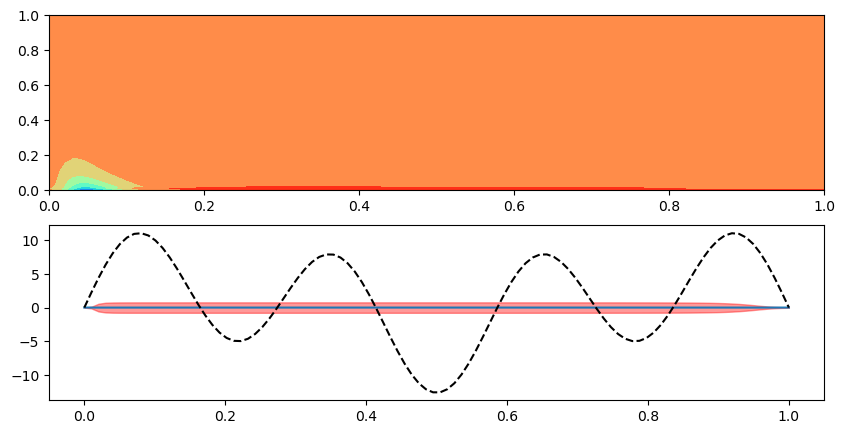

In [15]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
pr =  np.array(0.001)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1).to(device)

znn = model(X_star)

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,0].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')
U_sigma = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,1].cpu().sqrt().detach().numpy().flatten(), (xx,yy), method='cubic')
z_exact = exact_solution(xx,yy,pr)

fig, axs = plt.subplots(2,1, figsize=(10, 5))


axs[0].contourf(y, x, U_pred,cmap='rainbow')
axs[1].plot(y,U_pred[10,:])
axs[1].plot(y,z_exact[10,:],linestyle = "--",color = "black", label = "Exact Solution at t = 0 and t = 1.5")

axs[1].fill_between(x.reshape(-1), U_pred[10,:]+U_sigma[10,:],U_pred[10,:]-U_sigma[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

plt.show()